In [2]:
import PIL
# from keras import models
from keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import os
from tensorflow.keras import callbacks
import pandas as pd
from efficientnet.keras import EfficientNetB5 as Net
from efficientnet.keras import center_crop_and_resize, preprocess_input
from tensorflow.keras.models import load_model
import tensorflow.keras as keras
from keras import models


os.environ["CUDA_VISIBLE_DEVICES"]="1"

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

batch_size = 8
epochs = 5

# #Train
# dataframe = pd.read_csv('/media/tohn/HDD/VISION_dataset/Traindf_fold4_8_v2_balance_class.csv')
# base_dir = '/media/tohn/SSD/Images/Image1'
# os.chdir(base_dir)
# train_dir = os.path.join(base_dir, 'train')
# #validation
# valframe = pd.read_csv( '/media/tohn/HDD/VISION_dataset/Valdf_fold3_v2_balance_class.csv')
# validation_dir = os.path.join(base_dir, 'validation')


#Train
dataframe = pd.read_csv('/media/tohn/HDD/VISION_dataset/Traindf_fold4_8_v2.csv')
base_dir = '/media/tohn/SSD/Images/Image1'
os.chdir(base_dir)
train_dir = os.path.join(base_dir, 'train')
#validation
valframe = pd.read_csv( '/media/tohn/HDD/VISION_dataset/Valdf_fold3_v2.csv')
validation_dir = os.path.join(base_dir, 'validation')

In [3]:
# Load the pre-trained model
path_model = '/media/tohn/SSD/Machine-Unlearning-USAI-CCA-2024/models/modelEffNetB5_Unlearning_unfreezeB4_R2.h5'
# model  = load_model(path_model)
# model.summary()

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense#, Conv2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB5

# Step 1: โหลดโมเดลเดิมที่มี EfficientNet-B5
old_model = load_model(path_model)

# Step 2: ดึง EfficientNet-B5 จากโมเดลเดิม
efficientnet_b5_layer = old_model.get_layer('efficientnet-b5')  # ดึงเฉพาะ EfficientNet-B5
efficientnet_b5_layer.trainable =  False #True  # สามารถเลือกให้ฝึกต่อได้ หรือจะ freeze ก็ได้

In [5]:
# Step 3: สร้าง input layer ใหม่ที่มีขนาด (224, 224, 3)
new_input = Input(shape=(224, 224, 3), name='new_input')
height=width = 224
# # Create a new input layer that accommodates the concatenated input tensor
# new_input = Conv2D(3, (1, 1), activation='relu')(new_input)
# new_input = BatchNormalization()(new_input)

# Step 4: ต่อเลเยอร์ EfficientNet-B5 เข้ากับ input ใหม่
x = efficientnet_b5_layer(new_input)

In [6]:
# Step 5: เพิ่มเลเยอร์ Global Average Pooling, Dropout, และเลเยอร์ output (15 classes)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # สามารถปรับ dropout ตามความเหมาะสม
output = Dense(15, activation='softmax', name='prediction_layer')(x)  # 15 classes ใช้ softmax สำหรับ multi-class classification

# Step 6: สร้างโมเดลใหม่
new_model = Model(inputs=new_input, outputs=output)

# Step 7: Compile โมเดลใหม่ (ปรับ optimizer และ loss function ตามที่ต้องการ)
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 8: ดูสรุปโมเดลใหม่
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
new_input (InputLayer)       [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
prediction_layer (Dense)     (None, 15)                30735     
Total params: 28,544,255
Trainable params: 30,735
Non-trainable params: 28,513,520
_________________________________________________________________


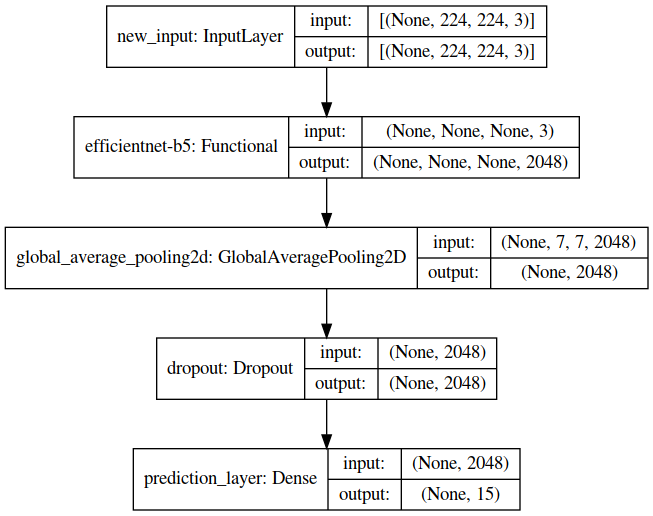

In [7]:
# from keras.models import Sequential
# from keras.layers import Dense
from keras.utils.vis_utils import plot_model
# model = Sequential()
# model.add(Dense(2, input_dim=1, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
plot_model(new_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

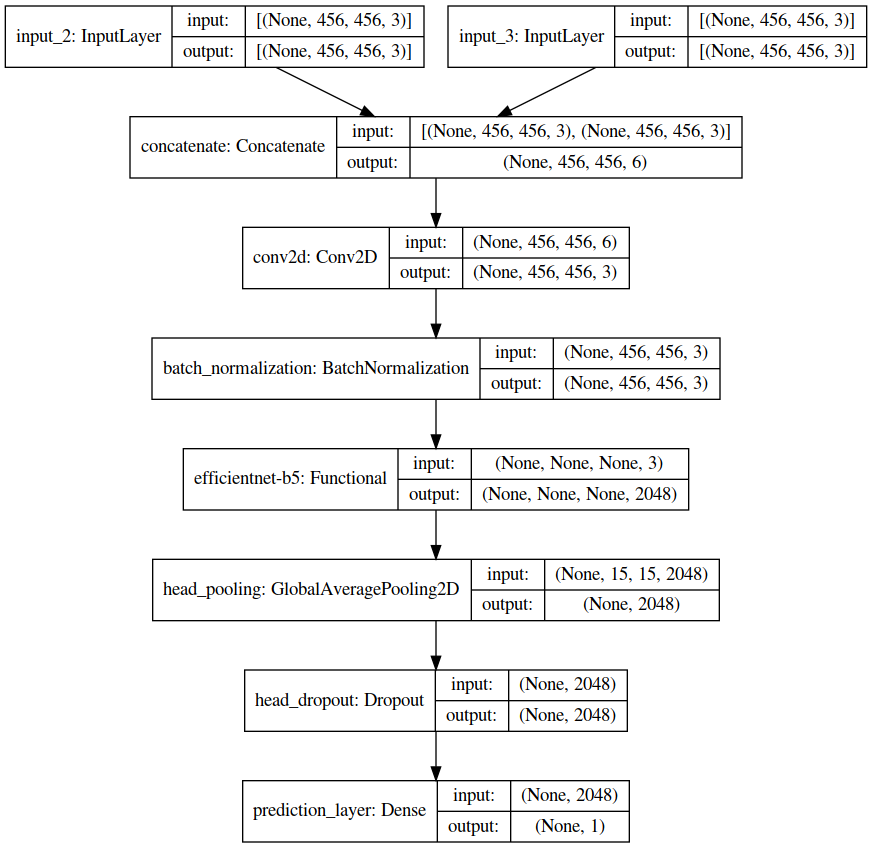

In [8]:
# from keras.models import Sequential
# from keras.layers import Dense
from keras.utils.vis_utils import plot_model
# model = Sequential()
# model.add(Dense(2, input_dim=1, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
plot_model(old_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
#showing before&after freezing
print('This is the number of trainable layers '
      'before freezing the conv base:', len(new_model.trainable_weights))
#conv_base.trainable = False  # freeze เพื่อรักษา convolutional base's weight
for layer in new_model.layers:
    layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(new_model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 2
This is the number of trainable layers after freezing the conv base: 0


In [10]:
# #Unfreez
# new_model.trainable = True
# set_trainable = False
# for layer in new_model.layers:
#     if layer.name == 'block5a_se_excite':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
# print('This is the number of trainable layers '
#       'after freezing the conv base:', len(new_model.trainable_weights))  

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = train_dir,
        x_col = 'Path Crop',
        y_col = 'Sub_class_New',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')
test_generator = test_datagen.flow_from_dataframe(
        dataframe = valframe,
        directory = validation_dir,
        x_col = 'Path Crop',
        y_col = 'Sub_class_New',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

Found 4369 validated image filenames belonging to 15 classes.
Found 621 validated image filenames belonging to 15 classes.


In [12]:
def avoid_error(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [13]:
 #Training
new_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = new_model.fit_generator(
      avoid_error(train_generator),
      steps_per_epoch= len(dataframe)//batch_size,
      epochs=epochs,
      validation_data=avoid_error(test_generator), 
      validation_steps= len(valframe) //batch_size)

/home/yupaporn/miniconda3/envs/USAI3/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/home/yupaporn/miniconda3/envs/USAI3/lib/python3.6/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
546/546 [==============================] - 138s 237ms/step - loss: 2.7829 - acc: 0.0739 - val_loss: 2.6360 - val_acc: 0.0601
Epoch 2/5
546/546 [==============================] - 128s 234ms/step - loss: 2.7948 - acc: 0.0695 - val_loss: 2.6353 - val_acc: 0.0601
Epoch 3/5
546/546 [==============================] - 128s 234ms/step - loss: 2.7966 - acc: 0.0702 - val_loss: 2.6344 - val_acc: 0.0601
Epoch 4/5
546/546 [==============================] - 127s 233ms/step - loss: 2.7901 - acc: 0.0748 - val_loss: 2.6354 - val_acc: 0.0601
Epoch 5/5
546/546 [==============================] - 128s 235ms/step - loss: 2.7938 - acc: 0.0699 - val_loss: 2.6360 - val_acc: 0.0584


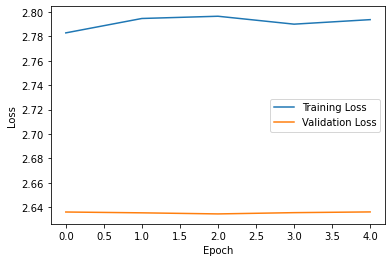

In [15]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()